In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import math
import bisect
pd.options.mode.chained_assignment = None

In [ ]:
gygi_rt = 90 * 0.01
inhouse_rt = 60 * 0.01
kelly_rt = 40 * 0.01

print("Gygi RT Threshold: ", gygi_rt)
print("Kelly RT Threshold: ", kelly_rt)
print("Inhouse RT Threshold: ", inhouse_rt)

Gygi RT Threshold:  0.9
Kelly RT Threshold:  0.4
Inhouse RT Threshold:  0.6


In [ ]:
entrapment_seq_path = r"C:\Users\Alex\Documents\Proteomes\MBR_Proteomes_March_2024\EntrapmentProteinPeptideSequences_50percent.txt"
with open(entrapment_seq_path) as f:
    entrapment_seqs = f.readlines()

entrapment_seqs_set = set()
for seq in entrapment_seqs:
    entrapment_seqs_set.add(seq.replace("\n", ""))
scaling_factor = 1 + 3105275 / 3608159
scaling_factor

1.8606258759661092

In [ ]:
# Native Peak Error Rate functions
def check_overlap_time(table, rt_delta):
    try:
        pip_apex = float(table["Peak RT Apex_y"])
        pip_int = float(table["Peak intensity_y"])
        ms_apex = float(table["Peak RT Apex_x"])
        ms_int = float(table["Peak intensity_x"])
    except:
        return -1
    if(abs(pip_apex-ms_apex) < rt_delta):
        if(abs(pip_apex-ms_apex) > 5):
            return 0 # Something fishy is going on, probably multiple elutions
        else:
            return 1
    else:
        return 0
    
def calculateErrorRate(table):
    return table["bad_transfers"] / (table["good_transfers"] + table["bad_transfers"])

def get_native_peak_error_table(o_peaks_path, c_peaks_path, censored_psm_path, rt_delta):
    # Read in the list of peptides that were censored
    censored_psms = pd.read_csv(censored_psm_path, sep = '\t')
    # Select the ones that were quantified in the initial FlashLFQ analysis
    original_peaks = pd.read_csv(o_peaks_path, sep = '\t')
    original_peaks = original_peaks[original_peaks["Peak RT Apex"] != "-"]

    censored_peaks = pd.merge(censored_psms, original_peaks, how = "inner", left_on=["File Name", "Full Sequence"], right_on=["File Name", "Full Sequence"])
    censored_peaks = censored_peaks[["File Name", "Full Sequence", "Peak RT Start", "Peak RT Apex", "Peak RT End", "Peak Charge", "Peak intensity"]]
    censored_peaks = censored_peaks.loc[~censored_peaks["Full Sequence"].str.contains("xidation")]

    # This will allow for comparison later, as all the new peaks were take from files named in this way
    censored_peaks["File Name"] = censored_peaks["File Name"].astype(str) + "-censored" 

    # Merge the old and new results
    new_peaks = pd.read_csv(c_peaks_path, sep = '\t')
    new_peaks = new_peaks.loc[(new_peaks["Peak Detection Type"] == "MBR") & (new_peaks["Random RT"] == False) & (new_peaks["Decoy Peptide"] == False)]
    new_peaks = new_peaks[["File Name", "Full Sequence", "Peak RT Start", "Peak RT Apex", "Peak RT End", "Peak Charge",  "Peak intensity", "PIP PEP", 'PIP Q-Value']]
    #peak_join = pd.merge(censored_peaks, new_peaks, how = "inner", left_on=["File Name", "Full Sequence", "Peak Charge"], right_on=["File Name", "Full Sequence", "Peak Charge"])
    peak_join = pd.merge(censored_peaks, new_peaks, how = "inner", left_on=["File Name", "Full Sequence"], right_on=["File Name", "Full Sequence"])

    #compare the old and new results (here, 1 means the match, 0 means they dont)
    peak_join["Agreement"] = peak_join.apply(lambda x: check_overlap_time(x, rt_delta), axis = 1)
    peak_join.sort_values(by = "Agreement", ascending=False, inplace=True)

    #compare the old and new results (here, 1 means the match, 0 means they dont)
    peak_join.drop_duplicates(subset = ["File Name", "Full Sequence"], keep = 'first', inplace=True)


    peak_join.sort_values(by = ['PIP Q-Value', "PIP PEP"], ascending=[True, True], inplace=True)
    peak_join["good_transfers"] = (peak_join["Agreement"] == 1).cumsum()
    peak_join["bad_transfers"] = (peak_join["Agreement"] == 0).cumsum()
    peak_join["error_rate"] = peak_join.apply(calculateErrorRate, axis = 1)

    return peak_join

In [ ]:
def process_peaks(o_peaks_path, c_peaks_path, censored_psm_path, human_file_pattern = "_1x02nguL_",
                   foreign_species = 'Saccharomyces cerevisiae', rt_delta = 0.5):

    # calculate the error rate for (presumably) native human transfers
    nper_table = get_native_peak_error_table( 
                            o_peaks_path = o_peaks_path,
                            c_peaks_path = c_peaks_path,
                            censored_psm_path = censored_psm_path,
                            rt_delta = rt_delta)

    peaks = pd.read_csv(o_peaks_path, sep = '\t')
    peaks = peaks.loc[peaks["File Name"].str.contains(human_file_pattern)]

    msms_detected_yeast_peaks = peaks.loc[(peaks["Peak Detection Type"] == "MSMS") &
                           (peaks["Organism"].str.contains(foreign_species))]
    msms_detected_yeast_peaks.drop_duplicates(subset = ["Full Sequence"], keep = 'first', inplace = True)
    msms_yeast_seqs = set(msms_detected_yeast_peaks["Full Sequence"].tolist())


    peaks = peaks.loc[(peaks["Peak Detection Type"] == "MBR") & (peaks["Random RT"] == False) & (peaks["Decoy Peptide"] == False)]
    #peaks = peaks.loc[(peaks["Organism"].str.contains('Homo sapiens')) | (peaks["Organism"].str.contains(foreign_species)) | (peaks["Organism"].str.contains("Arabidopsis thaliana"))]
    peaks.sort_values(by = ['PIP Q-Value', "PIP PEP"], ascending=[True, True], inplace=True)

    yeast_acceptor_count = 0
    yeast_count_list = []
    human_acceptor_count = 0
    human_count_list = []
    ecoli_acceptor_count = 0
    ecoli_count_list = []
    pct_yeast_col = []
    adj_pct_col = []
    b_pct_col = []
    c_pct_col = []
    pct_yeast = 0
    adj_pct = 0
    nper_index = 0

    for i in range(0, peaks.shape[0]):
        if(("Homo sapiens" in str(peaks["Organism"].iloc[i]))):
            if(peaks["Base Sequence"].iloc[i] in entrapment_seqs_set):
                ecoli_acceptor_count += 1
            else:
                human_acceptor_count += 1
        elif(foreign_species in str(peaks["Organism"].iloc[i])):
            if(not peaks["Full Sequence"].iloc[i] in msms_yeast_seqs):
                yeast_acceptor_count += 1
        #elif("ENTRAPMENT" in peaks["Organism"].iloc[i] ):
        #    ecoli_acceptor_count += 1

        yeast_count_list.append(yeast_acceptor_count)
        human_count_list.append(human_acceptor_count)
        ecoli_count_list.append(ecoli_acceptor_count)

        total_acceptors = max((yeast_acceptor_count + human_acceptor_count + ecoli_acceptor_count), 1)

        pct_yeast = 100*yeast_acceptor_count / total_acceptors

        # Foreign Peak Error Rate
        adj_pct = pct_yeast
        pct_yeast_col.append(pct_yeast)
        adj_pct_col.append(adj_pct)

        #Native Peak Error Rate
        while((nper_table['PIP Q-Value'].iloc[nper_index] < peaks['PIP Q-Value'].iloc[i]) & (nper_index < nper_table.shape[0]-1)):
            nper_index += 1

        # False Detection Error Rate
        scaled_arabida = ecoli_acceptor_count * scaling_factor
        c_pct_col.append( (100-pct_yeast) * (scaled_arabida / total_acceptors) )

        nper = nper_table["error_rate"].iloc[nper_index]
        b_pct_col.append( nper * 100 * human_acceptor_count  / total_acceptors)

    peaks["Percent Yeast"] = pct_yeast_col
    peaks["Percent Foreign Peak Transfers"] = adj_pct_col
    peaks["Percent Bad Native Peak Transfers"] = b_pct_col
    peaks["Percent Bad ID Transfers"] = c_pct_col
    peaks["Empirical FDR"] = np.array(adj_pct_col) + np.array(b_pct_col) + np.array(c_pct_col)
    peaks["Yeast Count"] = yeast_count_list
    peaks["Human Count"] = human_count_list
    peaks["Arabida Count"] = ecoli_count_list

    return peaks

In [ ]:
def FindRowIndexAt(table, q_value):
    index = bisect.bisect_left(table["MBR Q-Value"], q_value)
    if(index == table.shape[0]):
        return table.shape[0] - 1
    return index

In [ ]:
def smooth_q(q_list):
    real_q = [q_list[-1]]
    for i in range(len(q_list)-2, -1, -1):
        temp_val = min(real_q[-1], q_list[i])
        real_q.append(temp_val)
    real_q.reverse()
    return real_q

In [ ]:
#E coli dataset

in_house_res = process_peaks(o_peaks_path = r"D:\Human_Ecoli_TwoProteome_60minGradient\Human_FlashLFQ_7772_DonorPepQ_02\QuantifiedPeaks.tsv",
                          c_peaks_path = r"D:\Human_Ecoli_TwoProteome_60minGradient\CensoredHuman_FlashLFQ_7772_DonorPepQ_02\QuantifiedPeaks.tsv",
                          censored_psm_path = r"D:\Human_Ecoli_TwoProteome_60minGradient\RawData\MM_CensoredMzml_8_3_24\CensoredPsms.psmtsv",
                          human_file_pattern="Human_C18", foreign_species='Escherichia coli', rt_delta=inhouse_rt)
in_house_res.reset_index(drop=True, inplace=True)
in_house_res["index1p"] = in_house_res.index + 1

C:\Users\Alex\AppData\Local\Temp\ipykernel_48640\4201557948.py:25: DtypeWarning: Columns (10,11,12,13,14) have mixed types. Specify dtype option on import or set low_memory=False.
  original_peaks = pd.read_csv(o_peaks_path, sep = '\t')
C:\Users\Alex\AppData\Local\Temp\ipykernel_48640\4201557948.py:36: DtypeWarning: Columns (10,11,12,13,14) have mixed types. Specify dtype option on import or set low_memory=False.
  new_peaks = pd.read_csv(c_peaks_path, sep = '\t')
C:\Users\Alex\AppData\Local\Temp\ipykernel_48640\2186593231.py:11: DtypeWarning: Columns (10,11,12,13,14) have mixed types. Specify dtype option on import or set low_memory=False.
  peaks = pd.read_csv(o_peaks_path, sep = '\t')


In [ ]:
# Set global plotting parameters

plt.rcParams['axes.linewidth'] = 1
plt.rc('xtick', labelsize=12)    # fontsize of the tick labels
plt.rc('ytick', labelsize=12)  # fontsize of the tick labels

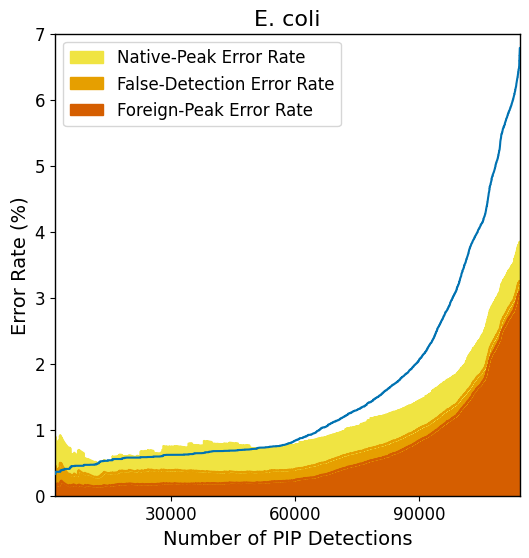

In [ ]:
#Plot E. coli data

plot_data = in_house_res

rowsStart = 2000
rowsEnd = plot_data.shape[0]
y_max = 7

fig, ax1 = plt.subplots()
fig.set_size_inches(6,6)
ax2 = ax1.twinx()

plot_data.plot.area(x = "index1p", y = ["Percent Foreign Peak Transfers", "Percent Bad ID Transfers", "Percent Bad Native Peak Transfers"], color = ['#D55E00', '#E69F00','#F0E442'], 
                   label = ["Foreign-Peak Error Rate", "False-Detection Error Rate","Native-Peak Error Rate"], ax = ax1)
ax1.set_xlim(rowsStart, rowsEnd)
ax1.set_ylim(0, ymax)
ax2.plot(range(rowsStart, rowsEnd), [100*x for x in plot_data["PIP Q-Value"].iloc[rowsStart:rowsEnd].tolist()], label = "PIP Q-Value", color = "#0072B2")
ax2.set_xlim(rowsStart, rowsEnd)
ax2.set_ylim(0, ymax)

# invert the legend
handles, labels = ax1.get_legend_handles_labels()
order = [2,1,0]
ax1.legend([handles[idx] for idx in order],[labels[idx] for idx in order], loc = "upper left", fontsize = 12)
ax1.set_xlabel("Number of PIP Detections", fontsize = 14)

ax1.yaxis.set_label_position("left")
ax1.yaxis.tick_left()
ax2.axis("off")

ax1.set_ylabel("Error Rate (%)", fontsize = 14)
ax1.set_title("E. coli", fontsize = 16)
ax1.xaxis.set_major_locator(plt.MaxNLocator(4))


fig.savefig(r"C:\Users\Alex\Source\Repos\MBR_metamorpheus\figures\PythonFigures\EcoliErrorRate.png", dpi=300, bbox_inches='tight')

In [ ]:
# Lim et al. Dataset

gygi_res = process_peaks(o_peaks_path = r"D:\GygiTwoProteome_PXD014415\FlashLFQ_7772_DonorPepQ_02\QuantifiedPeaks.tsv",
                          c_peaks_path = r"D:\GygiTwoProteome_PXD014415\CensoredData_FlashLFQ_7772_DonorPepQ_02\QuantifiedPeaks.tsv",
                          censored_psm_path = r"D:\GygiTwoProteome_PXD014415\MsConvertmzMLs\MM_NewPep_CensoredMzmls\CensoredPsms.psmtsv",
                          human_file_pattern="human_90", foreign_species='Saccharomyces cerevisiae', rt_delta=gygi_rt)
gygi_res.reset_index(drop=True, inplace=True)
gygi_res["index1p"] = gygi_res.index + 1

C:\Users\Alex\AppData\Local\Temp\ipykernel_48640\4201557948.py:25: DtypeWarning: Columns (10,11,12,13,14) have mixed types. Specify dtype option on import or set low_memory=False.
  original_peaks = pd.read_csv(o_peaks_path, sep = '\t')
C:\Users\Alex\AppData\Local\Temp\ipykernel_48640\4201557948.py:36: DtypeWarning: Columns (10,11,12,13,14) have mixed types. Specify dtype option on import or set low_memory=False.
  new_peaks = pd.read_csv(c_peaks_path, sep = '\t')
C:\Users\Alex\AppData\Local\Temp\ipykernel_48640\2186593231.py:11: DtypeWarning: Columns (10,11,12,13,14) have mixed types. Specify dtype option on import or set low_memory=False.
  peaks = pd.read_csv(o_peaks_path, sep = '\t')


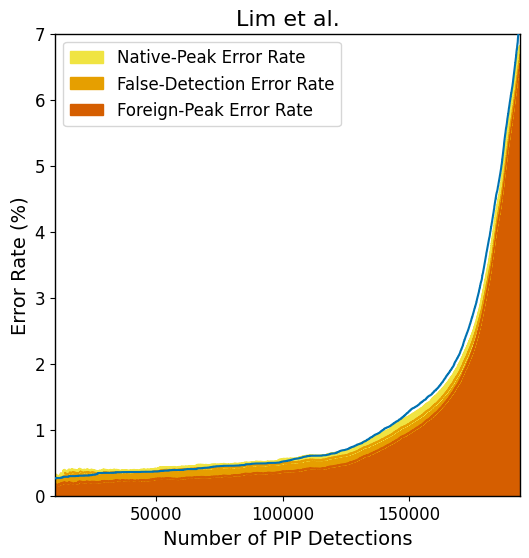

In [ ]:
# Plot Lim et al. data

plot_data = gygi_res
rowsStart = 10000
rowsEnd = plot_data.shape[0]

fig, ax1 = plt.subplots()
fig.set_size_inches(6,6)
ax2 = ax1.twinx()
ymax = 7

plot_data.plot.area(x = "index1p", y = ["Percent Foreign Peak Transfers", "Percent Bad ID Transfers", "Percent Bad Native Peak Transfers"], color = ['#D55E00', '#E69F00','#F0E442'], 
                   label = ["Foreign-Peak Error Rate", "False-Detection Error Rate","Native-Peak Error Rate"], ax = ax1)
ax1.set_xlim(rowsStart, rowsEnd)
ax1.set_ylim(0, ymax)
ax2.plot(range(rowsStart, rowsEnd), [100*x for x in plot_data["PIP Q-Value"].iloc[rowsStart:rowsEnd].tolist()], label = "PIP Q-Value", color = "#0072B2")
ax2.set_xlim(rowsStart, rowsEnd)
ax2.set_ylim(0, ymax)
#ax2.plot(range(rowsStart, rowsEnd), plot_data["Empirical FDR"].iloc[rowsStart:rowsEnd].tolist(), label = "Empirical FDR", color = 'red')

# invert the legend
handles, labels = ax1.get_legend_handles_labels()
order = [2,1,0]
ax1.legend([handles[idx] for idx in order],[labels[idx] for idx in order], loc = "upper left", fontsize = 12)
ax1.set_xlabel("Number of PIP Detections", fontsize = 14)

ax1.yaxis.set_label_position("left")
ax1.yaxis.tick_left()
#ax2.yaxis.set_label_position("left")
ax2.axis("off")

ax1.set_ylabel("Error Rate (%)", fontsize = 14)
#ax2.set_ylabel("MBR Score")
ax1.set_title("Lim et al.", fontsize = 16)
ax1.xaxis.set_major_locator(plt.MaxNLocator(4))

fig.savefig(r"C:\Users\Alex\Source\Repos\MBR_metamorpheus\figures\PythonFigures\LimErrorRate.png", dpi=300, bbox_inches='tight')

In [ ]:
#Single Cell Dataset

kelly_res = process_peaks(o_peaks_path = r"D:\Kelly_TwoProteomeData\FlashLFQ_7772_DonorPepQ_02\QuantifiedPeaks.tsv",
                          c_peaks_path = r"D:\Kelly_TwoProteomeData\CensoredData_FlashLFQ_7772_DonorPepQ_02\QuantifiedPeaks.tsv",
                          censored_psm_path = r"D:\Kelly_TwoProteomeData\MsConvertMzMls\MM_Censored_8_2_24\CensoredPsms.psmtsv",
                          human_file_pattern="_1x02nguL_", foreign_species='Saccharomyces cerevisiae', rt_delta=kelly_rt)
kelly_res.reset_index(drop=True, inplace=True)
kelly_res["index1p"] = kelly_res.index + 1

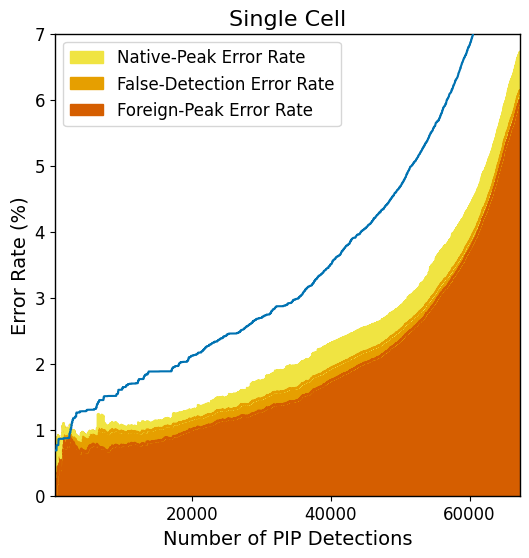

In [ ]:
#Plot Single Cell data

plot_data = kelly_res

rowsStart = 200
rowsEnd = plot_data.shape[0]

fig, ax1 = plt.subplots()
fig.set_size_inches(6,6)
ax2 = ax1.twinx()
ymax = 7

plot_data.plot.area(x = "index1p", y = ["Percent Foreign Peak Transfers", "Percent Bad ID Transfers", "Percent Bad Native Peak Transfers"], color = ['#D55E00', '#E69F00','#F0E442'], 
                   label = ["Foreign-Peak Error Rate", "False-Detection Error Rate","Native-Peak Error Rate"], ax = ax1)
ax1.set_xlim(rowsStart, rowsEnd)
ax1.set_ylim(0, ymax)
ax2.plot(range(rowsStart, rowsEnd), [100*x for x in plot_data["PIP Q-Value"].iloc[rowsStart:rowsEnd].tolist()], label = "PIP Q-Value", color = "#0072B2")
ax2.set_xlim(rowsStart, rowsEnd)
ax2.set_ylim(0, ymax)

# invert the legend
handles, labels = ax1.get_legend_handles_labels()
order = [2,1,0]
ax1.legend([handles[idx] for idx in order],[labels[idx] for idx in order], loc = "upper left", fontsize = 12)
ax1.set_xlabel("Number of PIP Detections", fontsize = 14)
#ax2.legend(loc="center left")

ax1.yaxis.set_label_position("left")
ax1.yaxis.tick_left()
ax2.yaxis.set_label_position("left")
ax2.axis("off")

ax1.set_ylabel("Error Rate (%)", fontsize = 14)
ax1.set_title("Single Cell", fontsize = 16)
ax1.xaxis.set_major_locator(plt.MaxNLocator(4))

fig.savefig(r"C:\Users\Alex\Source\Repos\MBR_metamorpheus\figures\PythonFigures\SingleCellErrorRate_wLegend.png", dpi=300, bbox_inches='tight')